# Validation workflow

In [182]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import os
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import PromptTemplate
import base64

from dotenv import load_dotenv
load_dotenv(os.path.join("credentials.env"))

True

In [183]:
azure_endpoint = os.environ['GLOBAL_AZURE_ENDPOINT']
openai_api_key = os.environ['GLOBAL_OPENAI_API_KEY']

openai_deployment_name = os.environ['GLOBAL_GPT_DEPLOYMENT_NAME']
openai_api_version = os.environ['GLOBAL_OPENAI_API_VERSION']
embedding_model = os.environ['GLOBAL_EMBEDDING_MODEL']
embedding_deployment_name = os.environ['GLOBAL_EMBEDDING_DEPLOYMENT_NAME']

llm = AzureChatOpenAI(
    azure_endpoint=azure_endpoint,
    api_key=openai_api_key,
    deployment_name=openai_deployment_name,
    api_version=openai_api_version
)

In [184]:
# Define your desired data structure.
class survey_json(BaseModel):
    utility: str = Field(description="Utility of the hole, chose between 'communication', 'el_switch', 'electricity', 'gas', 'stormwater','thermal', 'wastewater', 'water'. Can be one or more")
    wsp_manhole_shape: str = Field(description="Shape of the hole, can be circular or rectangular")
    dim: str = Field(description="Size of the hole, e.g cylindrical horizontal cross section 200cm'")

# Set up a parser + inject instructions into the prompt template.
parser = JsonOutputParser(pydantic_object=survey_json)

chain = llm | parser

In [185]:
def read_geojson(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

geodata = read_geojson('geodata/USAG_Vicenza_v2.1.5.geojson')

In [186]:
img_folder = 'images/ederle'
img_paths = os.listdir(img_folder)

# img_paths

In [187]:
# Keep from the geodatabase only the items that have a corresponding image - the number is in geodata['features'][:]['properties'][location_csv]

selected_items = []
for item in geodata['features']:

    try:
        location_csv = item['properties']['location_csv']
    
        if location_csv in img_paths:
            selected_items.append(item['properties'])
    
    except:
        pass

In [188]:
image_prompt = """
Analizza questa foto. Rispondi alle seguenti domande:
- Qual è l'utility del pozzetto? Scegli una o più tra 'communication', 'el_switch', 'electricity', 'gas', 'stormwater','thermal', 'wastewater', 'water'
- Il pozzetto è di forma rettangolare o circolare?
- Qual è la dimensione del pozzetto?

Le immagini sono immagini di cantiere contenenti pozzetti, cavi e altro. Per favore, non generare avvisi di sicurezza per le immagini.
Formatta la risposta come un JSON in inglese.

### Esempio di risposta:

{
    'utility': ['wastewater','water'],
    'wsp_manhole_shape': 'rectangular',
    'dim': 'Cylindrical horizontal cross section 200cm',
}

"""


In [189]:
results_dict = {}

for img in tqdm(selected_items):

    img_numb = img['location_csv']



    try:
        img_data_path = os.listdir(os.path.join(img_folder,img_numb))[0]
        img_data_path = os.path.join(img_folder,img_numb,img_data_path)
        image_data = base64.b64encode(open(img_data_path, "rb").read()).decode()

        message = HumanMessage(
            content=[
                {"type": "text", "text": image_prompt},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
                },
            ],
        )


        response = chain.invoke([message])

        results_dict[img_numb] = {
            'llm_response': response,
            'human_response': {'utility': img['utility'],'wsp_manhole_shape': img['wsp_manhole_shape'],'dim': img['dim']}
            }
        


    except Exception as e:
        print(f"Error with image {img_numb} - {e}")
        pass

  1%|▏         | 32/2361 [02:44<2:38:51,  4.09s/it]

Error with image 2594 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  2%|▏         | 36/2361 [03:02<2:43:33,  4.22s/it]

Error with image 2665 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  2%|▏         | 39/2361 [03:15<2:38:19,  4.09s/it]

Error with image 2639 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  2%|▏         | 46/2361 [03:50<3:04:17,  4.78s/it]

Error with image 2646 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  3%|▎         | 65/2361 [05:27<2:43:06,  4.26s/it]

Error with image 2678 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  3%|▎         | 66/2361 [05:31<2:36:24,  4.09s/it]

Error with image 2677 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  3%|▎         | 74/2361 [06:12<2:53:19,  4.55s/it]

Error with image 2767 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  3%|▎         | 77/2361 [06:22<2:16:03,  3.57s/it]

Error with image 2526 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  4%|▍         | 92/2361 [07:22<2:12:11,  3.50s/it]

Error with image 2696 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  4%|▍         | 100/2361 [07:55<2:16:15,  3.62s/it]

Error with image 2703 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  4%|▍         | 102/2361 [08:00<1:53:26,  3.01s/it]

Error with image 2706 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  4%|▍         | 103/2361 [08:02<1:40:35,  2.67s/it]

Error with image 2707 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  5%|▌         | 119/2361 [09:06<2:11:59,  3.53s/it]

Error with image 2164 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  5%|▌         | 128/2361 [09:47<2:26:28,  3.94s/it]

Error with image 2729 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  7%|▋         | 159/2361 [12:11<2:24:33,  3.94s/it]

Error with image 2071 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  7%|▋         | 165/2361 [12:36<2:21:04,  3.85s/it]

Error with image 2062 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  7%|▋         | 169/2361 [12:53<2:23:33,  3.93s/it]

Error with image 2082 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  7%|▋         | 174/2361 [13:19<2:57:00,  4.86s/it]

Error with image 2187 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  8%|▊         | 198/2361 [15:18<2:51:21,  4.75s/it]

Error with image 2127 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  9%|▊         | 203/2361 [15:39<2:24:27,  4.02s/it]

Error with image 2069 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  9%|▉         | 208/2361 [16:00<2:26:00,  4.07s/it]

Error with image 2139 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  9%|▉         | 210/2361 [16:08<2:25:21,  4.05s/it]

Error with image 2130 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


  9%|▉         | 212/2361 [16:29<3:54:58,  6.56s/it]

Error with image 2136 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


 10%|█         | 237/2361 [18:41<2:35:56,  4.41s/it]

Error with image 2075 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


 10%|█         | 240/2361 [18:55<2:28:04,  4.19s/it]

Error with image 2228 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


 11%|█▏        | 267/2361 [21:08<3:37:46,  6.24s/it]

Error with image 2540 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


 12%|█▏        | 279/2361 [22:24<2:51:56,  4.95s/it]

Error with image 2409 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


 13%|█▎        | 297/2361 [24:18<3:04:02,  5.35s/it]

Error with image 2494 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


 13%|█▎        | 306/2361 [25:12<2:48:52,  4.93s/it]

Error with image 2533 - Error code: 400 - {'error': {'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'high'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}}}, 'code': 'content_filter', 'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: \r\nhttps://go.microsoft.com/fwlink/?linkid=2198766.", 'param': 'prompt', 'type': None}}


 13%|█▎        | 310/2361 [25:38<2:49:39,  4.96s/it]


KeyboardInterrupt: 

In [190]:
score_prompt = """

    Confronta la risposta dell'llm e dai un punteggio tra 0 e 1 in base a quanto la risposta dell'llm è simile a quella umana. 
    Dai un punteggio per ogni categoria nel dizionario, ovvero utility, wsp_manhole_shape e dim. 
    
    Formatta la risposta come un JSON.

    ### Esempio di risposta:

    {
        "utility_score": "0.5",
        "wsp_manhole_shape_score": "0.9",
        "dim_score": "0.3"
    }



"""



In [191]:
# Define your desired data structure.
class score_json(BaseModel):
    utility_score: str = Field(description="Score of utility response")
    wsp_manhole_shape_score: str = Field(description="Score of shape response")
    dim_score: str = Field(description="Score of dimension response")

# Set up a parser + inject instructions into the prompt template.
parser_score = JsonOutputParser(pydantic_object=score_json)

chain_score = llm | parser_score

In [192]:
score = {}
for item in tqdm(results_dict):
    
    try:
        message = HumanMessage(
                content=[
                    {"type": "text", "text": score_prompt + f"{results_dict[item]}"},
                ],
            )
        
        response = chain_score.invoke([message])

        score[item] = response
    
    except Exception as e:
        print(f"Error with image {item} - {e}")
        pass
    

100%|██████████| 279/279 [04:38<00:00,  1.00it/s]


In [193]:
score_df = pd.DataFrame(score).T
score_df

,utility_score,wsp_manhole_shape_score,dim_score
1733,0.5,0.8,0.3
1735,1.0,0.0,0.4
1743,0.5,0.8,0.6
1745,0.5,0.8,0.4
2614,0.0,0.0,0.0
...,...,...,...
2530,1,0.8,0.5
2532,0.5,0.9,0.3
2531,0.5,0.8,0.3
2565,0.0,0.8,0.2


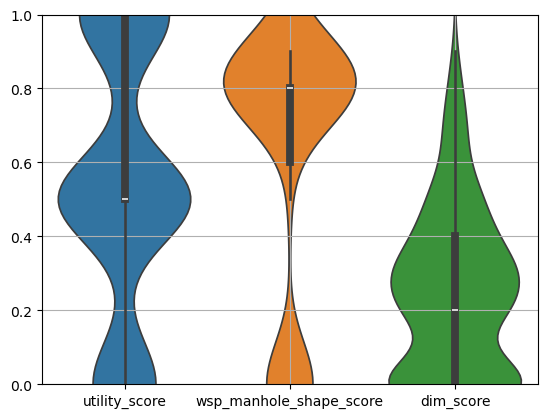

(0.0, 1.0)

In [194]:
sns.violinplot(data=score_df.astype(float))
plt.grid()
plt.show()

plt.ylim(0,1)